In [1]:
%matplotlib inline

In [2]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as pltcol

plt.style.use("project_style.mplstyle")

from models import RNNGC
from plotting_functions import multiimshow
from dataset import DatasetMaker
from tqdm import tqdm
import spatial_maps as sm

In [35]:
model = RNNGC()
model = model.load("./saved-models/RNNGC_49999.pkl")

In [36]:
# create data
res = 32
timesteps = 10
dataset = DatasetMaker()
rt, vt = dataset.generate_data(10000, timesteps)
inputs = (rt[:,0], vt)

In [37]:
# create "labels": run model without pruning
label_g = model(inputs).detach().numpy() # double check that states are alright
ratemaps = scipy.stats.binned_statistic_2d(rt[...,0].ravel().numpy(), rt[...,1].ravel().numpy(), label_g.reshape(-1, label_g.shape[-1]).T, bins = res)[0]

In [6]:
grid_scores = np.array([sm.gridness(ratemaps[i]) for i in range(len(ratemaps))])

cutoff = 0.15
low_gs_mask  = grid_scores < cutoff
high_gs_mask = grid_scores > 0.9

print(f"Cutoff: {cutoff}, number below: {low_gs_mask.sum()}, gs: {high_gs_mask.sum()}")

Cutoff: 0.15, number below: 30, gs: 201


Text(0, 0.5, 'CDF')

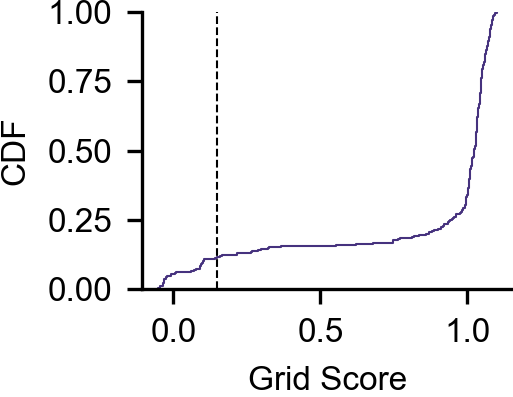

In [7]:
plt.figure()
plt.ecdf(grid_scores, linewidth = 0.5)
plt.vlines(cutoff, 0, 1, "k", linestyles="dashed", linewidth = 0.5)
plt.xlabel("Grid Score")
plt.ylabel("CDF")
# plt.savefig("./figures/gs_ecdf")

Text(0, 0.5, 'Count')

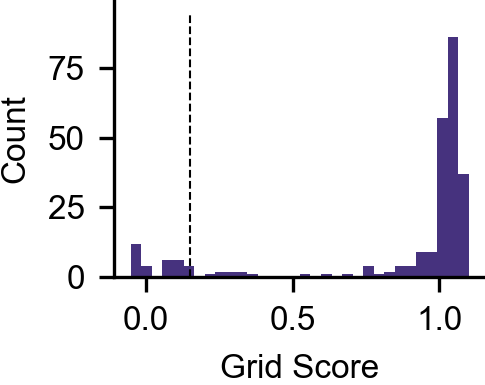

In [8]:
count, a, b = plt.hist(grid_scores, bins = 32);
plt.vlines(cutoff, 0, np.amax(count)*1.1, "k", linestyles="dashed", linewidth = 0.5)
plt.xlabel("Grid Score")
plt.ylabel("Count")
# plt.savefig("./figures/rnn_grid_score_cutoff")

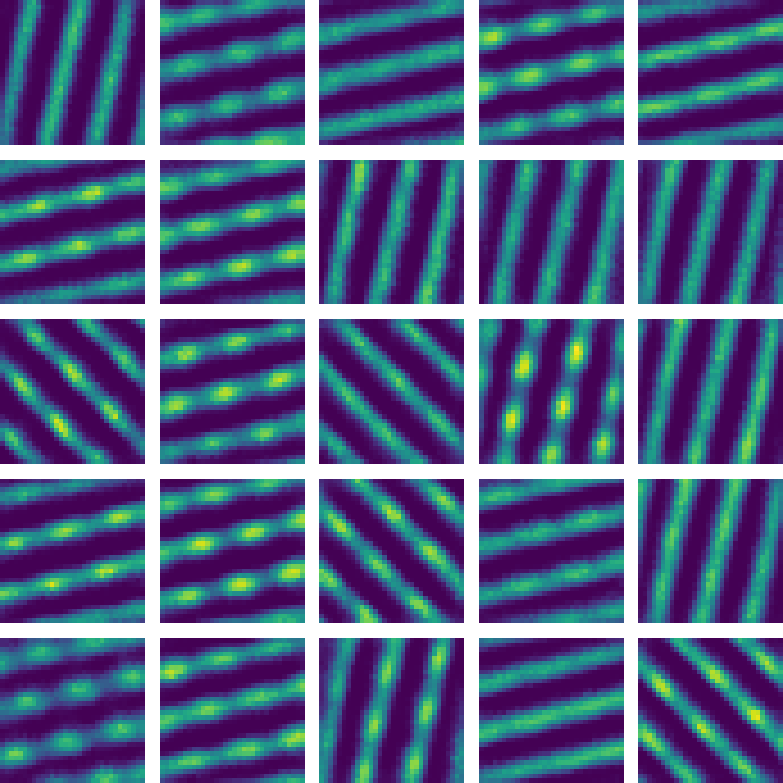

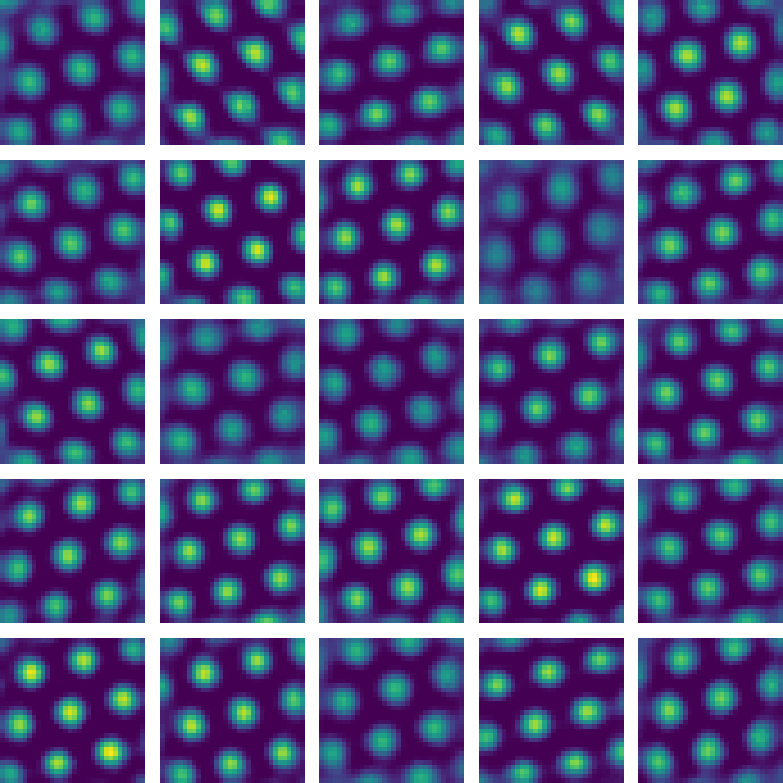

In [9]:
multiimshow(ratemaps[low_gs_mask][:25], figsize=(3,3), add_colorbar=False);
# plt.savefig(f"./figures/ratemaps_gs_below_cutoff")
multiimshow(ratemaps[high_gs_mask][:25], figsize = (3,3), add_colorbar = False);
# plt.savefig(f"./figures/ratemaps_gs_above_cutoff")

In [10]:
norm = pltcol.Normalize(vmin = np.amin(grid_scores), vmax = np.amax(grid_scores))
cmap = cm.viridis
grid_score_mappable = cm.ScalarMappable(norm, cmap)

def get_color(values):
    cmap = cm.viridis
    val = norm(np.mean(values))
    color = cmap(val)
    return color

In [11]:
# set indices
high_gs_inds = np.arange(model.ng)[high_gs_mask] # select indices of high GS units
low_gs_inds = np.arange(model.ng)[low_gs_mask]
all_inds = np.arange(model.ng) # all_inds :)

In [12]:
# prune low GS units
low_gs_color = get_color(grid_scores[low_gs_mask])
low_gs_prune_v = model.prune_forward(inputs, v_mask = torch.tensor(~low_gs_mask))
low_gs_error = torch.mean(torch.sum((torch.tensor(label_g) - low_gs_prune_v)**2, axis = -1), axis = 0)

Text(0, 0.5, 'Error')

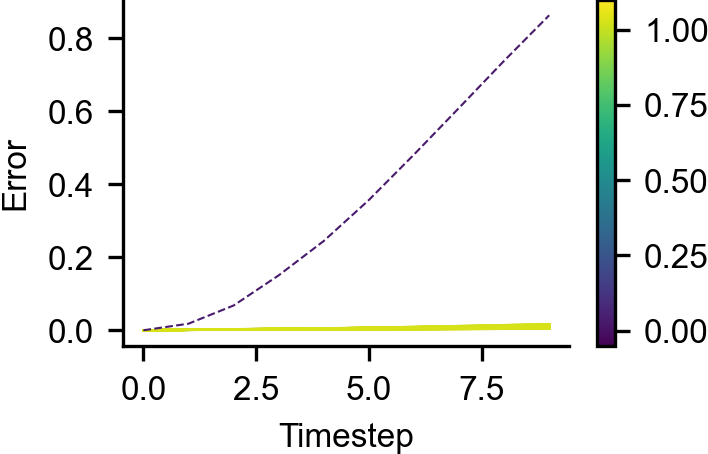

In [13]:
# prune only high GS units
plt.figure(figsize=(2.4,1.5))
for i in range(1000):
    prune_mask = np.ones(model.ng).astype("float32") # prune none
    prune_inds = np.random.choice(high_gs_inds, size = 100, replace = False)
    # Select randomly among high-GS units, number equal to non-grid units
    prune_mask[prune_inds] = 0
    # prune velocity input to selected cells
    g_prune_v = model.prune_forward(inputs, v_mask = torch.tensor(prune_mask))
    error = torch.mean(torch.sum((torch.tensor(label_g) - g_prune_v)**2, axis = -1), axis = 0)

    color = get_color(grid_scores[prune_inds])
    plt.plot(error.detach().numpy(), color = color, linewidth = 0.5, alpha = 0.5)

plt.plot(low_gs_error.detach().numpy(), "--", color = low_gs_color, linewidth = 0.5)
plt.colorbar(grid_score_mappable, ax = plt.gca())
plt.xlabel("Timestep")
plt.ylabel("Error")
# plt.savefig("./figures/prune_high_gs")

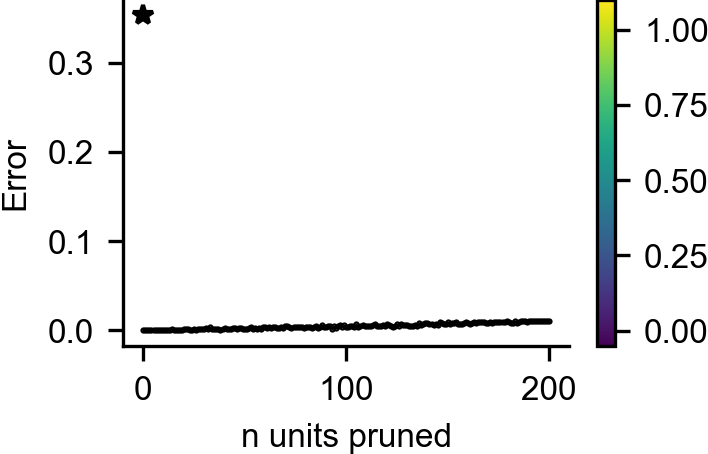

In [14]:
# prune only high GS units
plt.figure(figsize=(2.4,1.5))
for i in range(high_gs_mask.sum()):
    prune_mask = np.ones(model.ng).astype("float32") # prune none
    prune_inds = np.random.choice(high_gs_inds, size = i, replace = False)
    # Select randomly among high-GS units, number equal to non-grid units
    prune_mask[prune_inds] = 0
    # prune velocity input to selected cells
    g_prune_v = model.prune_forward(inputs, v_mask = torch.tensor(prune_mask))
    error = torch.mean(torch.sum((torch.tensor(label_g) - g_prune_v)**2, axis = -1), axis = 0)
    plt.plot(i, np.mean(error.detach().numpy()), "k.")

plt.plot(np.mean(low_gs_error.detach().numpy()), "k*", markersize = 5)
plt.colorbar(grid_score_mappable, ax = plt.gca())
plt.xlabel("n units pruned")
plt.ylabel("Error")
# plt.savefig("./figures/prune_high_gs")
plt.savefig("./incremental_prune_grids.png", dpi = 300)

In [15]:
prune_band_mask = np.ones(model.ng).astype("float32")
prune_band_mask[low_gs_mask] = 0.0

prune_grid_mask = np.ones(model.ng).astype("float32")
prune_grid_mask[high_gs_mask] = 0.0

g_prune_bands = model.prune_forward(inputs, v_mask = torch.tensor(prune_band_mask))
g_prune_grids = model.prune_forward(inputs, v_mask = torch.tensor(prune_grid_mask))


In [16]:
g_prune_bands.shape
band_pruned = scipy.stats.binned_statistic_2d(rt[:,-1,None,0].ravel().numpy(), rt[:,-1,None,1].ravel().numpy(), g_prune_bands[:,-1,None].reshape(-1, label_g.shape[-1]).T, bins = res)[0]
grid_pruned = scipy.stats.binned_statistic_2d(rt[:,-1,None,0].ravel().numpy(), rt[:,-1,None,1].ravel().numpy(), g_prune_grids[:,-1,None].reshape(-1, label_g.shape[-1]).T, bins = res)[0]

Text(0.5, 0.98, 'n = 201 grid units pruned, t = 10')

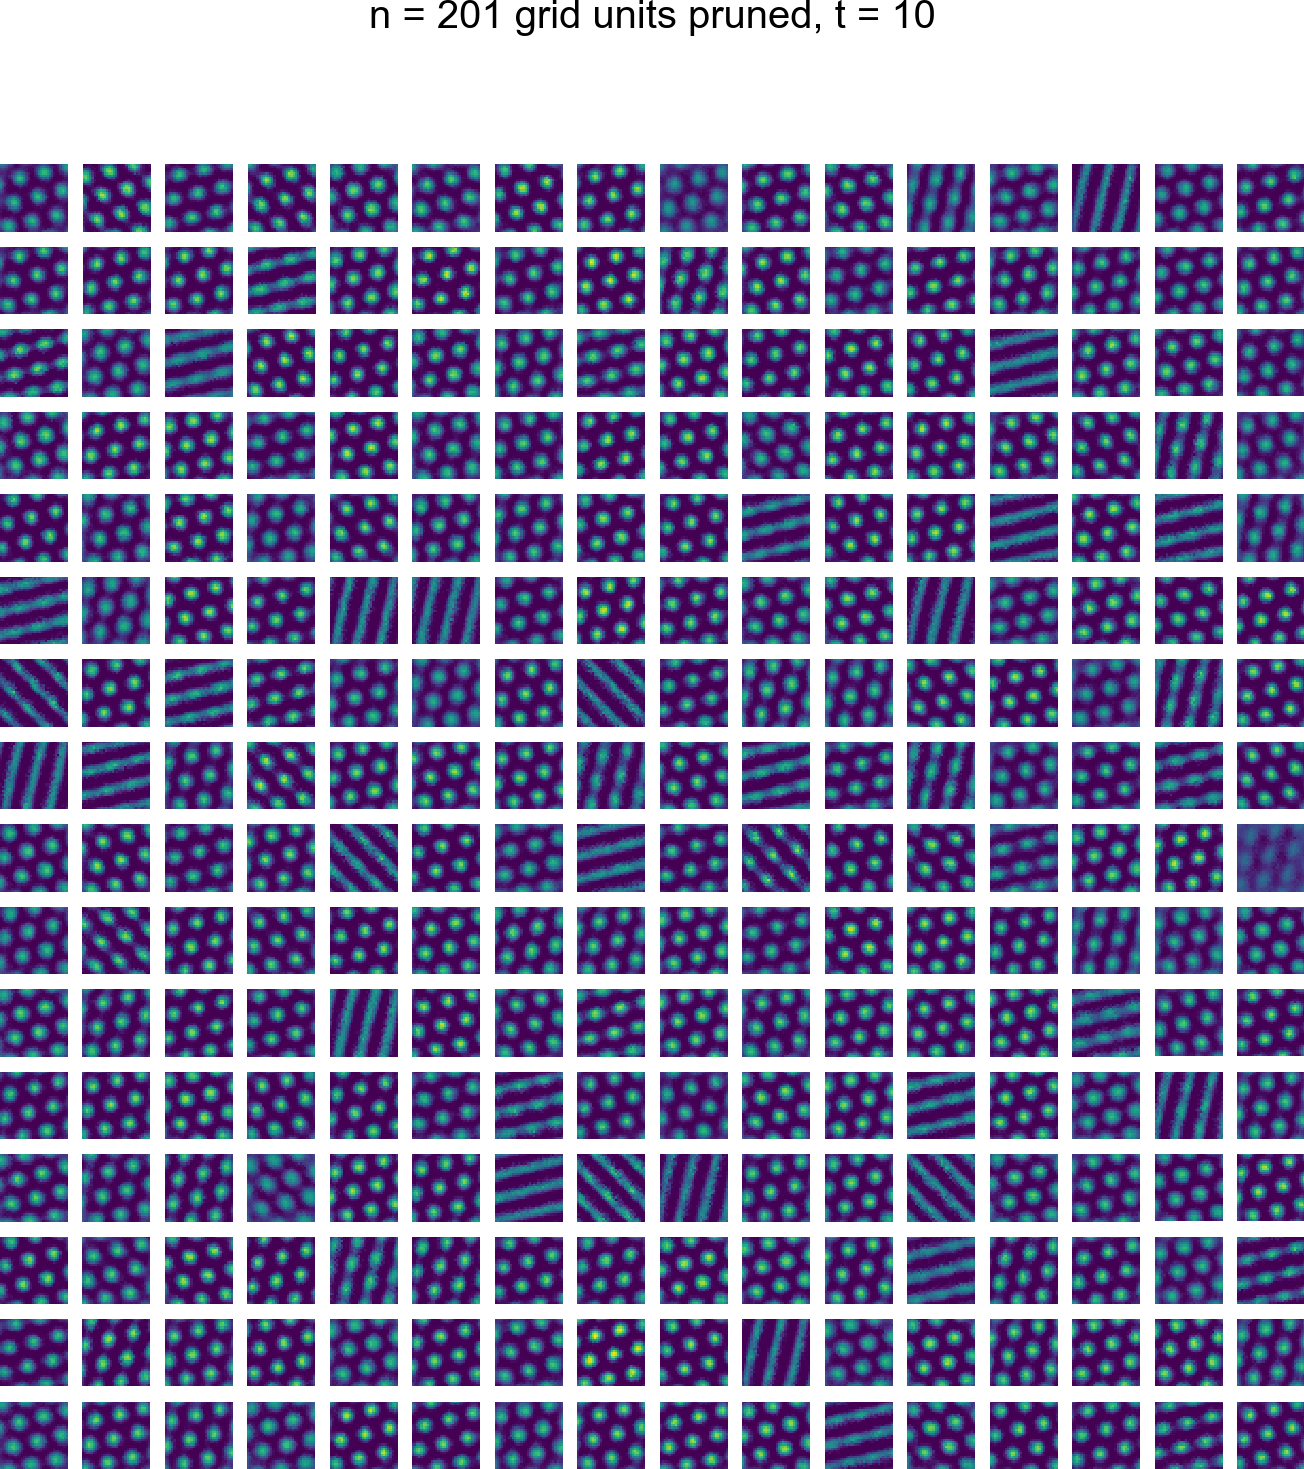

In [17]:
multiimshow(grid_pruned, figsize=(5,5), add_colorbar=False);
plt.suptitle(f"n = {high_gs_mask.sum()} grid units pruned, t = 10")

Text(0.5, 0.98, 'n = 30 band units pruned, t = 10')

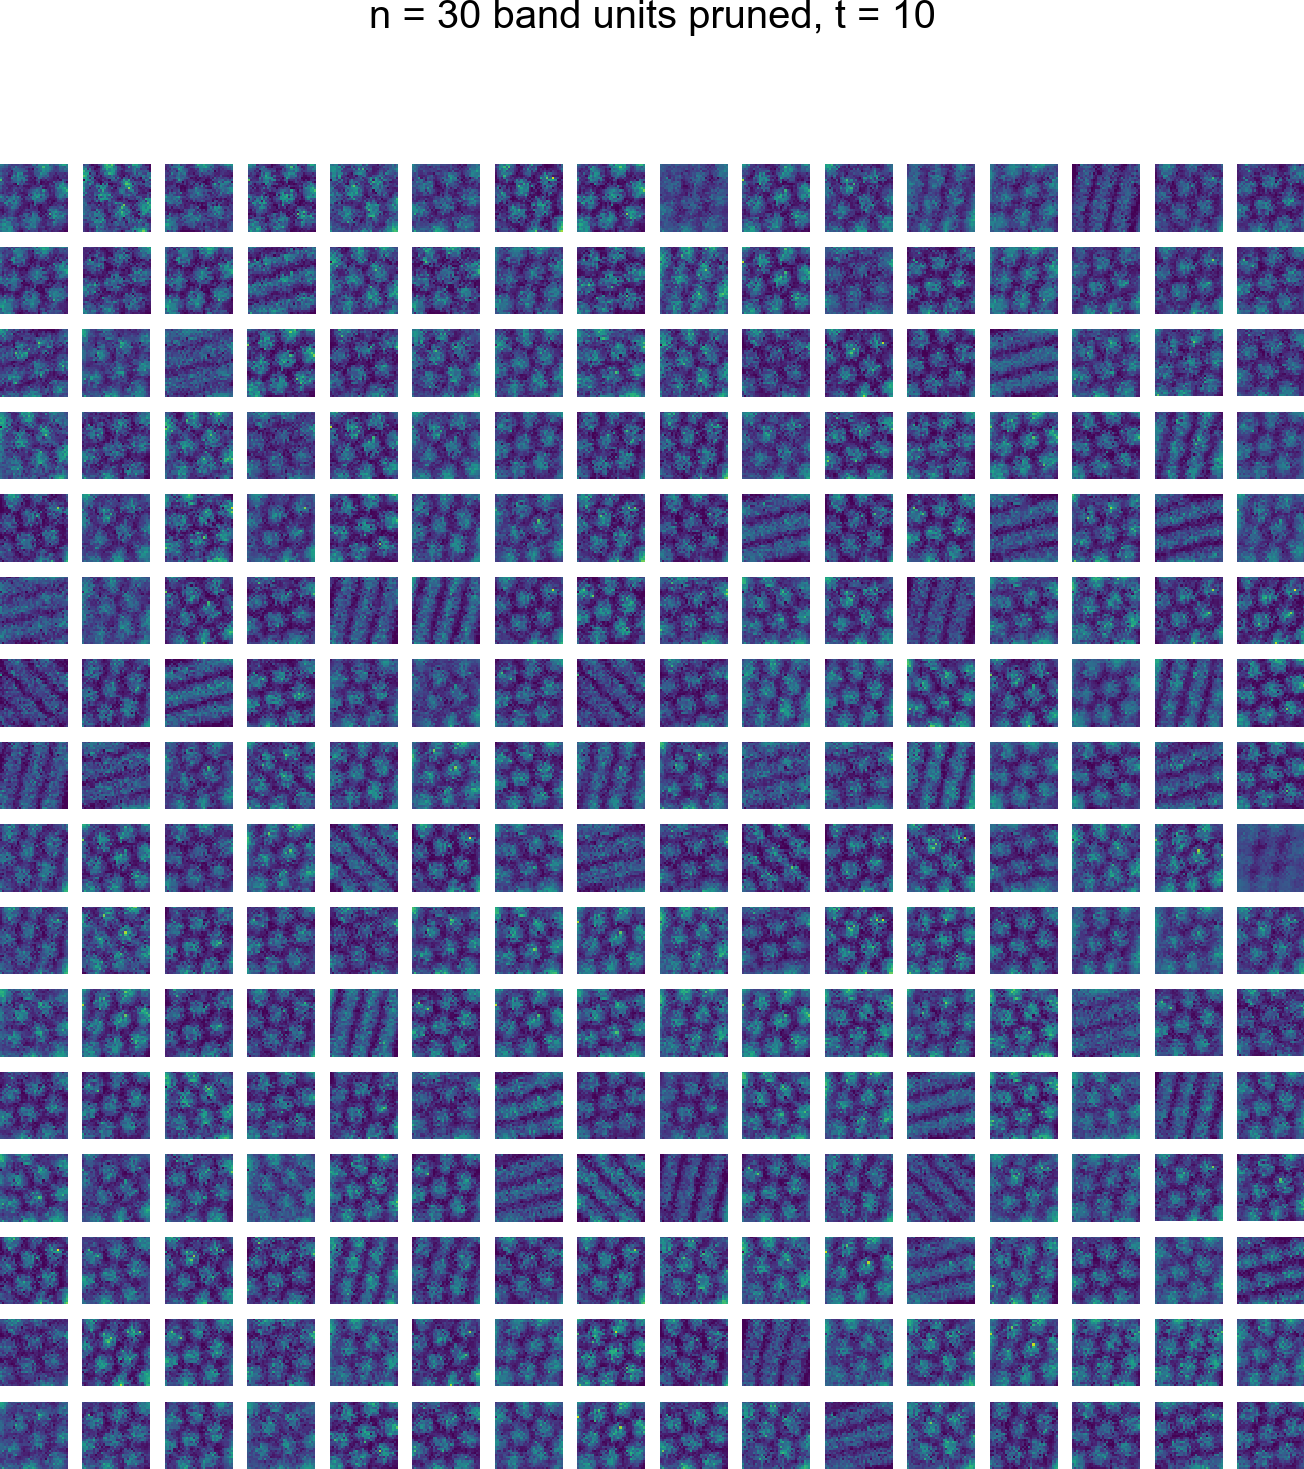

In [18]:
multiimshow(band_pruned, figsize=(5,5), add_colorbar=False);
plt.suptitle(f"n = {low_gs_mask.sum()} band units pruned, t = 10")


In [19]:
model.gg.weight.shape
grid_scores.shape

(256,)

# Prune band input to grids

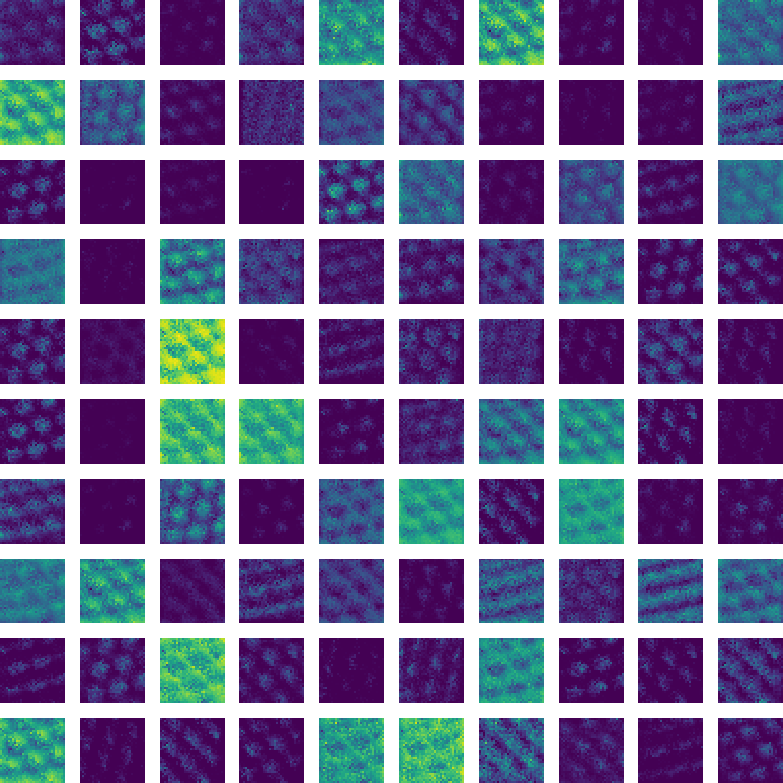

In [103]:
model = RNNGC()
model = model.load("./saved-models/RNNGC_49999.pkl")

with torch.no_grad():
    for i in high_gs_inds:
        for j in low_gs_inds:
            model.gg.weight[i][j] = 0.0

    g_no_b = model(inputs).detach().numpy()
    ratemaps = scipy.stats.binned_statistic_2d(rt[:,-1,0].ravel().numpy(), rt[:,-1,1].ravel().numpy(), g_no_b[:,-1].reshape(-1, label_g.shape[-1]).T, bins = res)[0]
    multiimshow(ratemaps[:100], figsize=(3,3), add_colorbar=False)#;, vmin = 0, vmax = None);

# Prune Grid inputs to bands

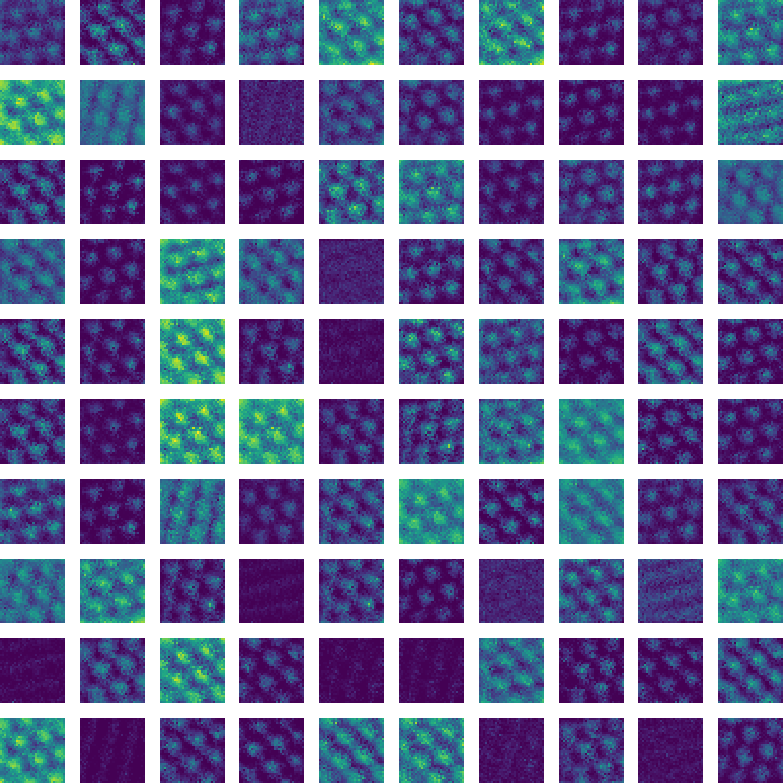

In [104]:
model = RNNGC()
model = model.load("./saved-models/RNNGC_49999.pkl")

with torch.no_grad():
    for i in low_gs_inds:
        for j in high_gs_inds:
            model.gg.weight[i][j] = 0.0

    b_no_g = model(inputs).detach().numpy()
    ratemaps = scipy.stats.binned_statistic_2d(rt[:,-1,0].ravel().numpy(), rt[:,-1,1].ravel().numpy(), b_no_g[:,-1].reshape(-1, label_g.shape[-1]).T, bins = res)[0]
    multiimshow(ratemaps[:100], figsize=(3,3), add_colorbar=False);#, vmin = 0, vmax = None);

# Prune Band2Band

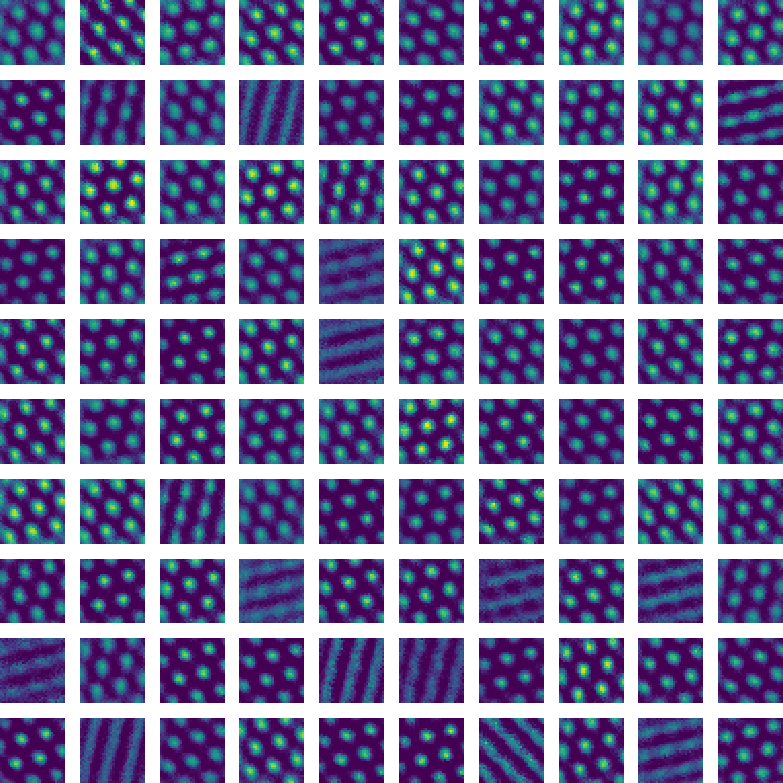

In [105]:
model = RNNGC()
model = model.load("./saved-models/RNNGC_49999.pkl")

with torch.no_grad():
    for i in low_gs_inds:
        for j in low_gs_inds:
            model.gg.weight[i][j] = 0.0

    b_no_b = model(inputs).detach().numpy()
    ratemaps = scipy.stats.binned_statistic_2d(rt[:,-1,0].ravel().numpy(), rt[:,-1,1].ravel().numpy(), b_no_b[:,-1].reshape(-1, label_g.shape[-1]).T, bins = res)[0]
    multiimshow(ratemaps[:100], figsize=(3,3), add_colorbar=False);#,vmin = 0, vmax = None);

# Prune Grid2Grid

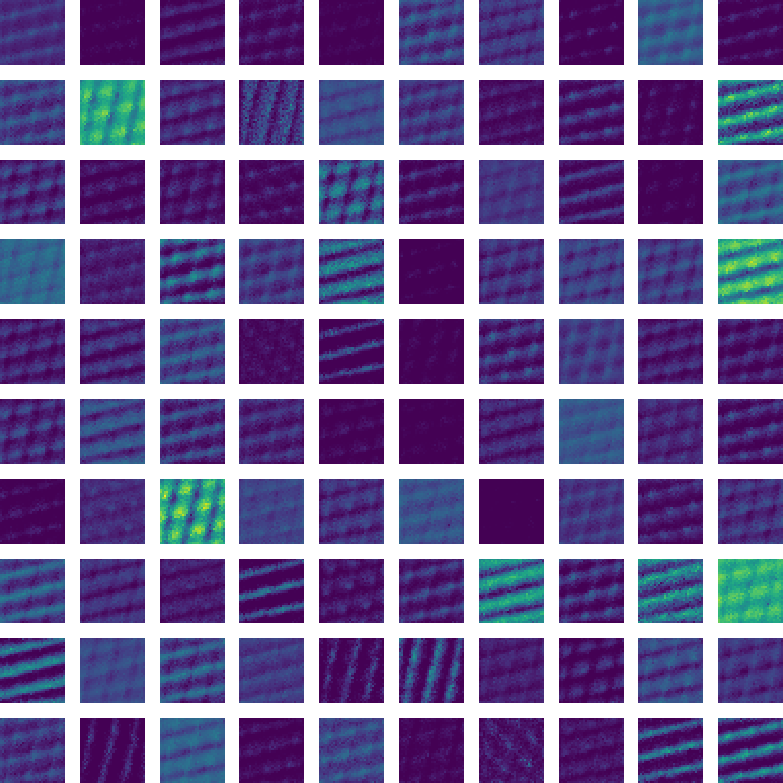

In [106]:
model = RNNGC()
model = model.load("./saved-models/RNNGC_49999.pkl")

with torch.no_grad():
    for i in high_gs_inds:
        for j in high_gs_inds:
            model.gg.weight[i][j] = 0.0

    g_no_g = model(inputs).detach().numpy()
    ratemaps = scipy.stats.binned_statistic_2d(rt[:,-1,0].ravel().numpy(), rt[:,-1,1].ravel().numpy(), g_no_g[:,-1].reshape(-1, label_g.shape[-1]).T, bins = res)[0]
    multiimshow(ratemaps[:100], figsize=(3,3), add_colorbar=False);#, vmin = 0, vmax = None);

In [92]:
model = RNNGC()
model = model.load("./saved-models/RNNGC_49999.pkl")

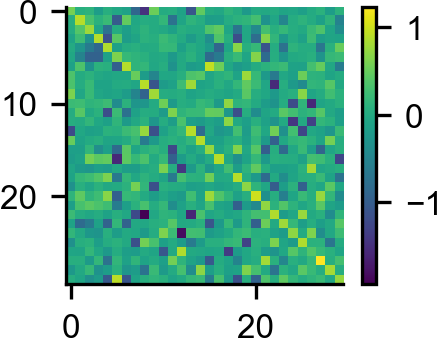

In [94]:
model.gg.weight
plt.imshow(model.gg.weight[low_gs_mask][:,low_gs_mask].detach())
plt.colorbar()

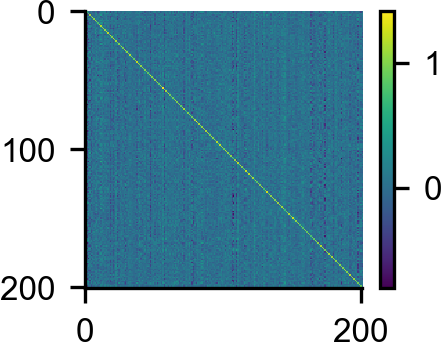

In [95]:
model.gg.weight
plt.imshow(model.gg.weight[high_gs_mask][:,high_gs_mask].detach())
plt.colorbar()

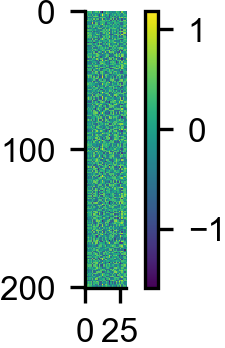

In [97]:
model.gg.weight
plt.imshow(model.gg.weight[high_gs_mask][:,low_gs_mask].detach())
plt.colorbar()

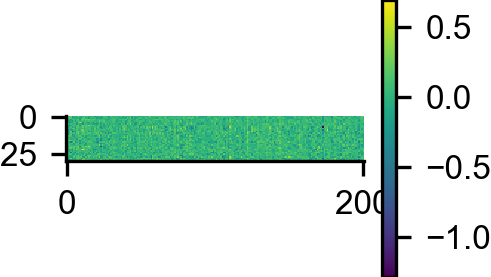

In [98]:
model.gg.weight
plt.imshow(model.gg.weight[low_gs_mask][:,high_gs_mask].detach())
plt.colorbar()